In [73]:
import matplotlib.pyplot as plt
import numpy as np
from math import *

import seaborn as sns
sns.set_style('darkgrid')

import ipywidgets as widgets

$$\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial t^2}, 0 < x < L, L = 1$$

$$u(0, t) = 0, u(L, t) = 0, u(x,0 )= x(1 - x/L)^2$$


$$\frac{v_j^{m + 1} - v_j^{m}}{\Delta t} = \frac{v_{j+1}^m - 2v_j^m + v_{j - 1}^m}{2h^2} + \frac{v_{j+1}^{m+1} - 2v_j^{m + 1} + v_{j - 1}^{m +1}}{2h^2}$$

Можно переписать как: 

$$ a_jv_{j+1}^{n+1} + b_jv_j^{n+1} + c_jv_{j-1}^{n+1} = d_j $$

Расчёт по схеме Кранка — Николсона требует использования метода прогонки для решения системы линейных уравнений на величины $v_j^{m+1}, \;\; j = 1, ... , N-1$

Или в матричном виде, где: 

В левой части стоит трехдиагональная матрица. Задам её тремя списками:

* `b` - элементы главной диагонали
* `a` - элементы диагонали под главной
* `с` - элементы диагонали над главной
* `d` - вектор-столбец правой части

В каждом списке элементы с индексами $0 ... n$, при этом $a_0 = 0$ и $c_N = 0$.

$$ a_j = \left\{\begin{matrix}
0, & j = 1\\ 
-\frac{\tau}{2h^2}, & j = 1, ..., N-1;
\end{matrix}\right. $$
$$b_j = 1 + \frac{\tau}{h^2};$$
$$ c_j = \left\{\begin{matrix}
-\frac{\tau}{2h^2}, & j = 1, ..., N-2\\ 
0, & j = N-1;
\end{matrix}\right.\ $$
$$d_j = \frac{\tau(v_{j+1}^m + (-2 + \frac{2h^2}{\tau})v_j^m +v_{j-1}^m)}{2h^2}$$

То есть на каждом слое по времени я решаю эту систему с матрицей, "продвигающей по x"

### Создание матрицы и решение для трехдиагональной матрицы

Матрицу задаю в виде списков поддиагональных (`a`), диагональных (`b`) и наддиагональных (`c`) элементов.

Правая часть (`d`) будет генерироваться каждый раз отдельно.

In [74]:
def create_matrix(n, x_start, x_end, tau):
    
    h = (x_start - x_end)/n
    
    a = []
    b = []
    c = []
    
    for i in range(0, n-1):
        a.append(-0.5*tau/h**2)
        b.append(1 + tau/h**2)
        c.append(-0.5*tau/h**2)
        
    a[0] = 0
    c[n-2] = 0
    
    A = [a, b, c]
    
    return A

In [75]:
def solve_3diag(A, d, n):
    
    # A = [a, b, c]
    
    d_new = d.copy()
    b_new = A[1].copy()
    c_new = A[2].copy()
    a_new = A[0].copy()
    
    for i in range(0, n-1):
        k = a_new[i] / b_new[i-1]
        b_new[i] -= k*c_new[i-1]
        d_new[i] -= k*d_new[i-1]
    
    y = [i for i in range(n-1)]
    
    y[n-2] = d_new[n-2]/b_new[n-2]
    
    for i in range(n-3, -1, -1):
        y[i] = (d_new[i] - c_new[i]*y[i+1])/b_new[i]
        
    return y

In [76]:
#L = 1e3
L = 1
x_start = 0
x_end = L

u_0t = 0 
u_Lt = 0 

def u_x0(x):
    return x*((1 - x/L)**2) 

In [77]:
#сетка по пространственной координате
#N = 10000
N = 1000
h = (x_end - x_start)/N

#T = 1000 #точек по времени
T = 10
t_start = 0
#t_end = 5000000
t_end = 1
print(h)
tau = (t_end - t_start)/T  #шаг по времени
print(tau)

0.001
0.1


In [78]:
#значения в начальный момент времени t=0 во всех точках x_j
u_x0_s = []
x_s = []
for j in range(0, N+1):
    x_s.append(x_start + j*h)
    u_x0_s.append(u_x0(x_s[j]))

In [79]:
A = create_matrix(N, x_start, x_end, tau)


In [80]:
def Lu(j, m):
    return (u[m][j+1] - 2*u[m][j] + u[m][j-1]) / h**2

In [81]:
u = [] #решения по слоям (список списков)

#в начальный момент времени
u.append(u_x0_s)

for m in range(T):
    
    #собирать правую часть
    d = []
    for j in range(1, N):
        d.append(u[m][j] + tau / 2 * Lu(j, m))
    
    #решение
    sol = solve_3diag(A, d, N)
    #значения на концах
    sol.insert(0, 0)
    sol.append(0)
    
    u.append(sol)

In [82]:
u_max = []
t = []

for i in range(len(u)):
    u_max.append(max(u[i]))
    t.append(t_start+tau*i)

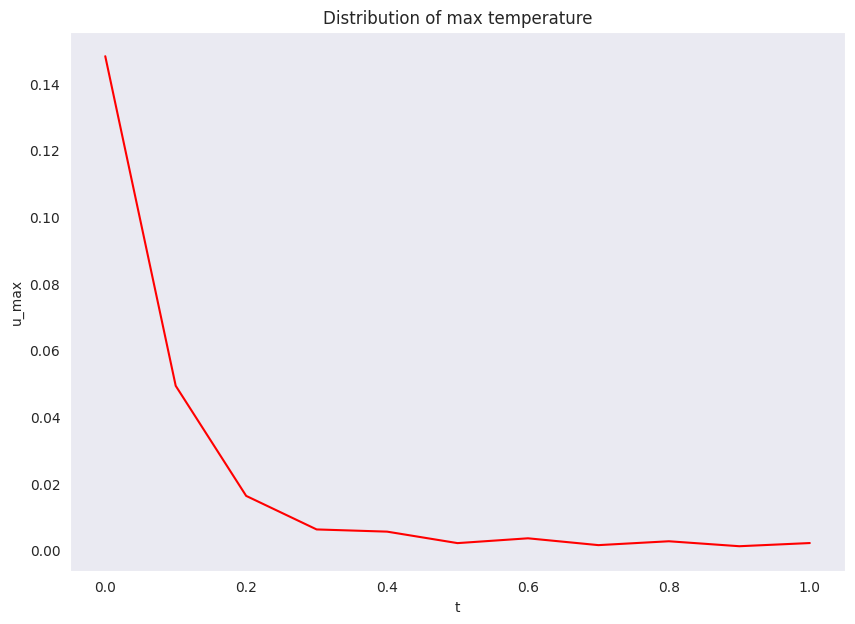

In [83]:

plt.figure(figsize=(10, 7))
plt.plot(t, u_max, 'r', label = 'u_max')
plt.grid()
plt.title('Distribution of max temperature')
plt.xlabel('t')
plt.ylabel('u_max')
#plt.yscale('log')
plt.show()

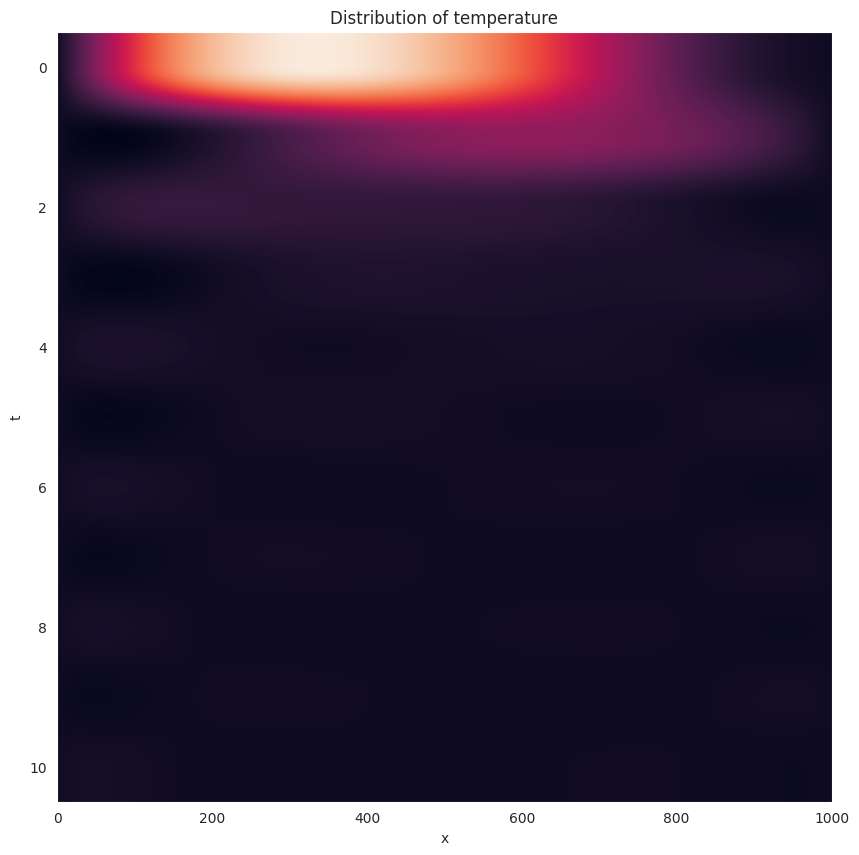

In [84]:
plt.figure(figsize=(10, 10))
plt.imshow(u, aspect='auto')
plt.grid()
plt.title('Distribution of temperature')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

$$ |a_j| + |c_j| < |b_j|$$

$$ | \tau < h^2|$$

$$ h = \frac{L}{N} $$
$$\tau < \frac{L^2}{N^2}$$
$$L >= N\sqrt{\tau}$$
Зависимость L от начальных условий

Если L > 1000, все падает